Hi
I am Ahmet. I am a student studying computer engineering at Mugla University. For my test, I developed a transformers model based on encoder-decoder architecture similar to trocr, which is known for its high accuracy in various OCR metrics. Due to the high computational requirements of training a transformer model from scratch, I trained it on a small dataset and observed good performance. To meet the requirement of 80% accuracy, I fine-tune a pre-trained version of trocr.

* # Sections
## Section 1: Prepare Dataset
## Section 2: Train
### Section 2.1: Create Vision Encoder Decoder Model from scratch
### Section 2.2: Using Pre Trained OCR
## Section 3: Evaluation and Result





# What Value I Can Add to the Project
### Create LoRA modules for each font
In the paper titled "**Combining OCR Models for Reading Early Modern Printed Books" by Seuret, Mathias et al.**, it is noted that **OCR performance is significantly affected by font style**. The authors found that **selecting fine-tuned models with font group recognition greatly improves the results**.

LoRA (Low-Rank Adaptation of Large Language Models) is a PEFT (Parameter-Efficient Fine-Tuning) technique that allows for the fine-tuning of modules on transformer models without changing the base model parameters. This technique can also be applied to vision transformers. **By using LoRA, modules can fine-tune for each font while utilizing base model adaptation with minimal computational power**. As part of the team responsible for creating the vision transformers course for **Hugging Face**, I have developed a course on using LoRA to fine-tune vision transformer models. While it is not officially released, you can access it here: [johko/notebooks/Unit 3 - Vision Transformers/LoRA-Image-Classification](https://github.com/johko/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/LoRA-Image-Classification.ipynb).


### Postprocessing with NLP techniques
NLP techniques can use for postprocessing. After applying OCR to a document, NLP models like BERT can be used to correct errors in the OCR output **by predicting the correct words within the context of the surrounding text**. BERT could use at understanding the context of a word in a sentence. It can provide replacements for words that might have been misrecognized by the OCR system [1](https://medium.com/doma/using-nlp-bert-to-improve-ocr-accuracy-385c98ae174c) [2](https://www.plugger.ai/blog/how-does-nlp-help-with-text-recognition). I have taken the CENG 3526 Natural Language Processing course and can develop a system that utilizes such techniques.

## Set-up environment

In [ ]:
! pip install -U -q accelerate
! pip install -U -q transformers
! pip install -q datasets jiwer

Import necessery librarys

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Section 1 Prepare Dataset

To prepare the data for training, I utilize a synthetic data generator designed for printed documants. The library i use for this task is TextRecognitionDataGenerator which is the same library used to pretrain trocr on synthetic text. For additional dataset i found [Spanish Redonda (Round Script) 16th-17th Century](https://readcoop.eu/model/spanish-redonda-round-script-16th-17th-century/). Although this datasets isn't publicly available, I contacted the author and they agreed to share if it is for research purposes, not for commercial use.

### Font
Given the limited computational power, it is necessary to fine-tune TROCR using fonts that are similar. I use online font identification websites such as [myfonts](https://www.myfonts.com/) and [whatfontisthis](https://www.whatfontis.com/) to find the most similar fonts. Once identified, I download these fonts from [OnlineWebFonts](https://www.onlinewebfonts.com).

Also disturtion, random_skew and random_blur added for preparing model to diffent edge cases

Example image to identify fonts

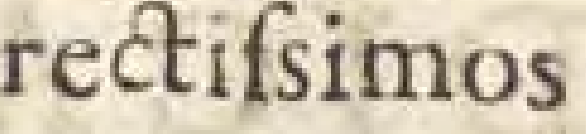

In [ ]:
!pip install -q trdg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2


In [ ]:
!trdg -c 9000 -d 3 -w 1 -f 64 -l es --random_skew --random_blur -fd /content/drive/MyDrive/ocr/fonts -dt /content/drive/MyDrive/ocr/dictionary/ep_es.txt --output_dir /content/drive/MyDrive/ocr/13k_es_mixed_lib

!trdg -c 4000 -d 3 -w 1 -f 64 -l es --random_skew --random_blur -fd /content/drive/MyDrive/ocr/fonts -dt /content/drive/MyDrive/ocr/dictionary/ep_es.txt --output_dir /content/drive/MyDrive/ocr/13k_es_mixed_lib

2024-03-24 12:59:38.963521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 12:59:38.963577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 12:59:38.965277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 12:59:40.104396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100% 9000/9000 [03:35<00:00, 41.67it/s]
2024-03-24 13:03:21.902078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been r

In [2]:
dataset_directory ="/content/drive/MyDrive/ocr/13k_es_mixed_lib"
model_save_folder = "/content/drive/MyDrive/trocr_es13k_finetune"
len(os.listdir("/content/drive/MyDrive/ocr/13k_es_mixed_lib"))

12999

## Prepare data for training

In [3]:
file_names = []
texts = []

for file_name in os.listdir(dataset_directory):
    text = file_name.split('_')[0].replace('-', ' ')
    with open(os.path.join(dataset_directory, file_name), 'r') as file:
        file_names.append(file_name)
        texts.append(file_name.split('_')[0])

# Create a DataFrame from the lists
df = pd.DataFrame({'file_name': file_names, 'text': texts})

df

,file_name,text
0,parecido_3000.jpg,parecido
1,christiana_3001.jpg,christiana
2,alguna_3002.jpg,alguna
3,aviendose_3003.jpg,aviendose
4,buscando_3004.jpg,buscando
...,...,...
12994,mismas_994.jpg,mismas
12995,van_995.jpg,van
12996,mismas_996.jpg,mismas
12997,possible_997.jpg,possible


In [ ]:
sub_df = df.iloc[:500]

In [ ]:
train_df, test_df = train_test_split(sub_df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Section 2 Train Models

### Section 2.1 Create Transformers Based Model From Scratch

I will follow the same architecture with Trocr which is stated "**To effectively train the TrOCR model, the encoder can be initialized with pre-trained ViT-style models (Dosovitskiy et al. 2021; Touvron et al. 2021; Bao, Dong, and Wei 2021) while the decoder can be initialized with pre-trained BERT-style models (Devlin et al. 2019; Liu et al. 2019; Dong et al. 2019; Wang et al. 2020b), respectively** in paper."

I'll use vit-base-patch16-224-in21k for processing images and bert-base-uncased for breaking down text into tokens. Transformers are more precise than CNN-based OCR. The top 5 OCRs in the IAM dataset utilize transformers. However, transformers typically require more training data. TrOCR, for instance, was trained on a dataset with 684 million lines of text. Since I don't have the computational power for that, I've developed a Proof of Concept model trained and evaluated on a smaller dataset.

In [ ]:
from transformers import ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel
from datasets import load_dataset

from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, VisionEncoderDecoderModel

config_encoder = ViTConfig()
config_decoder = BertConfig()
config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)

model = VisionEncoderDecoderModel(config=config)
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
model.config.num_beams = 2

In [ ]:
class test_sp(Dataset):
    def __init__(self, root_dir, df,processor, image_processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.image_processor = image_processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.image_processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
train_dataset = test_sp(root_dir=dataset_directory + "/",
                           df=train_df,
                           processor=tokenizer, image_processor=image_processor)
eval_dataset = test_sp(root_dir=dataset_directory + "/",
                           df=test_df,
                           processor=tokenizer, image_processor=image_processor)

In [ ]:
from transformers import Trainer, TrainingArguments
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model=model.to(device)
model.train()
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=60,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=32,
    # warmup_steps=50,
    # weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=150,
    # eval_steps=25
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)
trainer.train()

save_folder = "/content/drive/MyDrive/generated_vision_encoder_decoder_20-5"
trainer.save_model(save_folder)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
150,4.393500
300,2.491000
450,1.667000
600,1.369800
750,1.188600
900,0.960500
1050,0.610800
1200,0.324000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Removed shared te

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(save_folder)

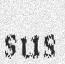

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


actual text: sus, predicted text: sus


In [ ]:
def test_model(directory):
    test_image = dataset_directory + "/" + directory
    image = Image.open(test_image).convert("RGB")
    display(image)
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print("actual text: " + directory.split("_")[0] + ", predicted text: " + generated_text)

test_model(sub_df.iloc[1]["file_name"])

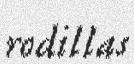

actual text: rodillas, predicted text: rodillas


In [ ]:
test_model(sub_df.iloc[0]["file_name"])

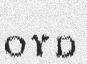

actual text: oyd, predicted text: civil


In [ ]:
test_model(sub_df.iloc[2]["file_name"])

# Section 2.2 Fine Tune Transformers base TrOCR Model

In [8]:
class SpanishPrintedDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Initializing the training and evaluation datasets

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-str')
train_dataset = SpanishPrintedDataset(root_dir=dataset_directory + "/",
                           df=train_df,
                           processor=processor)
eval_dataset = SpanishPrintedDataset(root_dir=dataset_directory + "/",
                           df=test_df,
                           processor=processor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Number of training examples: 10399
Number of validation examples: 2600
pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [3]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 1.0
model.config.num_beams = 2

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    fp16=True,
    output_dir="./content/res",
    logging_steps=2,
    save_steps=1000,
    eval_steps=250,
    num_train_epochs=3


)

I will evaluate the model on the Character Error Rate (CER).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-12-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,

)
trainer.train()
trainer.save_model("/content/drive/MyDrive/trocr_es14k_finetune_mixed")

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
250,0.531900,0.418512,0.077621
500,0.141100,0.255717,0.062421
750,0.098900,0.109571,0.025894
1000,0.275700,0.106937,0.024332
1250,0.126000,0.035760,0.005707
1500,0.004300,0.034781,0.007510
1750,0.067300,0.021516,0.002704
2000,0.000600,0.007545,0.000961
2250,0.000400,0.000706,0.000240
2500,0.000400,0.000479,0.000060


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 2, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any

Load fine tuned model

In [3]:
model_save_folder = "/content/drive/MyDrive/trocr_es14k_finetune_mixed"
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained(model_save_folder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

## Section 3: Evaluation and Result

['text_0.png', 'text_1.png', 'text_2.png', 'text_3.png', 'text_4.png', 'text_5.png', 'text_6.png', 'text_7.png', 'text_8.png', 'text_9.png', 'text_10.png', 'text_11.png', 'text_12.png', 'text_13.png', 'text_14.png', 'text_15.png', 'text_16.png', 'text_17.png', 'text_18.png', 'text_19.png', 'text_20.png', 'text_21.png', 'text_22.png', 'text_23.png', 'text_24.png', 'text_25.png', 'text_29.png', 'text_30.png', 'text_31.png', 'text_32.png', 'text_33.png', 'text_34.png', 'text_35.png', 'text_36.png', 'text_37.png', 'text_38.png', 'text_39.png', 'text_40.png', 'text_41.png', 'text_42.png', 'text_43.png', 'text_44.png', 'text_45.png', 'text_46.png', 'text_47.png', 'text_48.png', 'text_49.png', 'text_50.png', 'text_51.png', 'text_53.png', 'text_54.png', 'text_55.png', 'text_56.png', 'text_57.png', 'text_58.png', 'text_59.png', 'text_60.png', 'text_61.png', 'text_62.png', 'text_63-1.png', 'text_63-2.png', 'text_64.png', 'text_65.png', 'text_66.png', 'text_67-1.png', 'text_67-2.png', 'text_68.pn

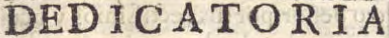

dedicatoria


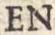

en


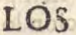

los


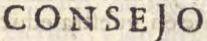

consejo


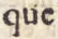

que


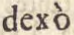

dexó


á


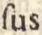

fus


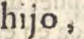

hijo


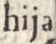

hija


mayores


vna


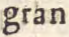

gran


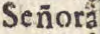

seña


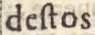

defos


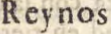

reynos


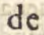

de


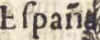

fipańri


que


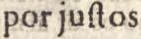

porjutos


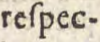

relpec


tos


fe


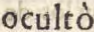

oculto


flu


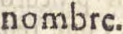

nombre


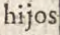

hijos


mios


tan


cierto


que


el


virtulóo


fer


es


el


que


por


obli


gacion


han


ide


dar


a


los


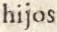

hijos


fus


pa


dres


y


por


el


que


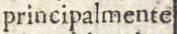

principalmente


ellos


les


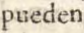

pueden


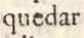

quedar


obligados


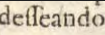

defeandó


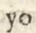

yo


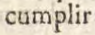

cumplir


en


cito


la


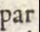

par


te


que


me


toca


executaros


en


la


vuetra


no


aviendole


ferido


nuefl


In [ ]:
import re

def process_image_folders(directory_path, model, processor):
    def get_numeric_parts(folder_name):
        """Extracts all numeric parts from a folder name."""
        return [int(part) for part in re.findall(r'\d+', folder_name)]

    def sort_folders(folder_names):
        """Sorts folder names based on embedded numeric sequences."""
        return sorted(folder_names, key=get_numeric_parts)

    folder_names = os.listdir(directory_path)
    sorted_folder_names = sort_folders(folder_names)
    sorted_folder_names
    print(sorted_folder_names)
    generated_text_result = ""

    for folder_name in sorted_folder_names:
        folder_path = os.path.join(directory_path, folder_name)
        image = Image.open(folder_path).convert("RGB")
        display(image)
        pixel_values = processor(image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        if generated_text_result == "":
            generated_text_result += generated_text
        else:
            generated_text_result = generated_text_result + " " + generated_text

        print(generated_text)

    return generated_text_result

directory_path = '/content/drive/MyDrive/ocr/extracted_images/page_1'
result = process_image_folders(directory_path, model, processor)

In [ ]:
result

'dedicatoria en los consejo que dexó á fus hijo hija mayores vna gran seña defos reynos de fipańri que porjutos relpec tos fe oculto flu nombre hijos mios tan cierto que el virtulóo fer es el que por obli gacion han ide dar a los hijos fus pa dres y por el que principalmente ellos les pueden quedar obligados defeandó yo cumplir en cito la par te que me toca executaros en la vuetra no aviendole ferido nuefl'

In [ ]:
true_text = "DEDICATORIA EN LOS CONSEJOS que dexo a sus hijo, e hija mayores una gran Señora destos Reynos de España que por justos respec- tos se ocultó su nombre. SIENDO (hijos mios) tan cierto, que el virtuoso ser es el que por obli- gacion han de dar a los hijos sus Pa- dres, y por el que principalmente ellos les pueden quedar obligados; desseando yo cumplir en esto la par te que me toca, y executaros en la vuestra, no aviendose servido nues"

# Metrices

I believe that the most appropriate method to measure the similarity between two texts in this case is by using the Levenshtein distance. The Levenshtein distance is a metric designed to determine the similarity between two strings. It is calculated as the smallest number of single-character edits (insertions, deletions, or substitutions) needed to transform one string into the other. This method is valuable because when the Levenshtein distance is high, it **can significantly improve the accuracy of OCR predictions by using a dictionary to identify the most similar word to a falsely predicted one**.

In [ ]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


In [ ]:
def accuracy(predicted_text, actual_text):
    predicted_text = predicted_text.replace("\n", "")
    actual_text = actual_text.replace("\n", "")
    lev_distance = levenshtein(predicted_text, actual_text)
    return (1 - lev_distance / max(len(predicted_text), len(actual_text))) * 100

print(accuracy(result.lower(), true_text.lower()))


85.77981651376146


Another useful metric is cosine similarity, which creates a vector of texts and then measures how similar two vectors are. It's commonly used in natural language processing to measure text similarity. The accuracy of cosine similarity depends on the number of similar and different words in the given text, making it highly suitable for testing OCR results.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text1, text2):
    vectorizer = CountVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    csim = cosine_similarity(vectors)
    return csim[0][1]
calculate_cosine_similarity(result, true_text)

0.813976578514622

## Predicting Test Pages

In [ ]:
!pip install -q "python-doctr[tf]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import math
import os
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import PIL

detection_model = ocr_predictor(det_arch = "db_resnet50", pretrained = True, assume_straight_pages=True,straighten_pages=True)
detection_model.det_predictor.model.postprocessor.bin_thresh = 0.35

def convert_coordinates(geometry, page_dim):
    len_x = page_dim[1]
    len_y = page_dim[0]
    (x_min, y_min) = geometry[0]
    (x_max, y_max) = geometry[1]
    x_min = math.floor(x_min * len_x)
    x_max = math.ceil(x_max * len_x)
    y_min = math.floor(y_min * len_y)
    y_max = math.ceil(y_max * len_y)
    return [x_min, x_max, y_min, y_max]

def get_coordinates(output):
    page_dim = output['pages'][0]["dimensions"]
    text_coordinates = []
    for obj1 in output['pages'][0]["blocks"]:
        for obj2 in obj1["lines"]:
            for obj3 in obj2["words"]:
                converted_coordinates = convert_coordinates(
                                           obj3["geometry"],page_dim
                                          )
                text_coordinates.append(converted_coordinates)
    return text_coordinates

#Save
def save_bounded_texts(image, bounds, output_dir):
    for i, b in enumerate(bounds):
        p0, p1, p2, p3 = [b[0],b[2]], [b[1],b[2]], [b[1],b[3]], [b[0],b[3]]
        min_x = min(p0[0], p1[0], p2[0], p3[0])
        min_y = min(p0[1], p1[1], p2[1], p3[1])
        max_x = max(p0[0], p1[0], p2[0], p3[0])
        max_y = max(p0[1], p1[1], p2[1], p3[1])

        # Crop the image to the bounding box dimensions
        cropped_image = image.crop((min_x, min_y, max_x, max_y))

        # Save the cropped image
        cropped_image.save(os.path.join(output_dir, f'text_{i}.png'))

#Show
def draw_bounds(image, bound):
    draw = ImageDraw.Draw(image)
    for b in bound:
        p0, p1, p2, p3 = [b[0],b[2]], [b[1],b[2]], \
                         [b[1],b[3]], [b[0],b[3]]
        draw.line([*p0,*p1,*p2,*p3,*p0], fill='blue', width=2)
    return image

def process_image(image_path, model, save_path):
    img = DocumentFile.from_images(image_path)
    result = model(img)
    output = result.export()

    graphical_coordinates = get_coordinates(output)

    image = PIL.Image.open(image_path)
    save_bounded_texts(image, graphical_coordinates, save_path)

    image = PIL.Image.open(image_path)
    result_image = draw_bounds(image, graphical_coordinates)

    plt.figure(figsize=(15, 15))
    plt.imshow(result_image)
    plt.show()



In [6]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

In [7]:
image_path = "/content/drive/MyDrive/ocr/test/page14/page14_1.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/page14_1"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

Folder '/content/drive/MyDrive/ocr/extracted_text_image/page14_1' created successfully.


In [ ]:
image_path = "/content/drive/MyDrive/ocr/test/page14/page14_2.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/page14_2"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

In [ ]:
image_path = "/content/drive/MyDrive/ocr/test/page15/page15_1.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/pdf15_1"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

In [ ]:
image_path = "/content/drive/MyDrive/ocr/test/page15/page15_2.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/pdf15_2"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

In [ ]:
image_path = "/content/drive/MyDrive/ocr/test/page16/page16_1.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/pdf16_1"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

In [ ]:
image_path = "/content/drive/MyDrive/ocr/test/page16/page16_2.png"
save_path = "/content/drive/MyDrive/ocr/extracted_text_image/pdf16_2"
create_folder_if_not_exists(save_path)
process_image(image_path, detection_model, save_path)

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf14_1'
result14_1 = process_image_folders(directory_path, model, processor)
result14_1

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf14_2'
result14_2 = process_image_folders(directory_path, model, processor)
result14_2

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf15_1'
result15_1 = process_image_folders(directory_path, model, processor)
result15_1

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf15_2'
result15_2 = process_image_folders(directory_path, model, processor)
result15_2

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf16_1'
result16_1 = process_image_folders(directory_path, model, processor)
result16_1

In [ ]:
directory_path = '/content/drive/MyDrive/ocr/extracted_text_image/pdf16_2'
result16_2 = process_image_folders(directory_path, model, processor)
result16_2

In [ ]:
page_14 = result14_1 + " " + result14_2
page_14

'si por quitar un pecado morta aueys de poner vuetra vida en pe ligro arrigala que es el mejor emplo que della podeys hazer y devuéra hazienda para efte fin en redemir cautuos y facar mugeres de pecado dotandolas liberalmen le caton dixó nunca hagas el bien porque fe fepa dad pues vos hin bueno aqualquiera obra con que huyreys de ha hiporéa pero tami poco efcondays las que han defer de buien exemplo pues es obliga cion de perfoñas tales el darlo y lo contranio tentacion en algunos nó hagays profellon de fantero pe ro íi de buen christiano no apro ueyśmas tampoco reproueys fauti dades mudofas fino efimad las cier tas y aprobadas y a effo toca elno fer mibalrero acordaos del rey s luys que no quillo ver con los ojos lo que mejor veya con la fe si por quitar un pecado morta aueys de poner vuetra vida en pe ligro arrigala que es el mejor emplo que della podeys hazer y devuéra hazienda para efte fin en redemir cautuos y facar mugeres de pecado dotandolas liberalmen le caton dixó nu

In [ ]:
page_15 = result15_1 + " " + result15_2
page_15

'imente mas ederrama por efa cau faflu fangreyque elel auerla heredado itan generolá y vivio defeminado ide ino perder ocacion en fervirle cumplir flu voluntad a vuestro confer que elege reys eipiritual docto yy hombre dé gran talento tened mucho refeto y dadle autoridad para que os diga libremente quantas verdades ave frra alma importanten en las colas tos cantes a ella obedecedle enterá mente con todo rendimiento y tal que no admitays razon para ló que os ordenerre en ellas materias por no perder el merito dela fe yy obe diencia clega que aqui la deue auer) tomad lu confejo pues eologiendó le con las partes dichas uo aura pelli gro de qúe defo metiendole en el gobierno de todo y querien do confequirl lo que pidiéri julto injulto que es propiedad dé igno santes no muy epiritales yy mas de huyr defó ganareys el dar credito oy autoridad atodas vuetras acciones eigiendole con ellas si bie lla negocacion de las colas pias toca principalmente al conferior el qual tiendo á propõo

In [ ]:
page_16 = result16_1 + " " + result16_2
page_16

'pro cada dia cuya deuocior feles hu cio obien arlos a los imperadores heri icos illy villya otros muchos los llunes oficio de difuntos los vier des los plallos pontenciales y of cio dela Cruz y viralo de oracion procurad no perderle penfando en jelfin para que fuyfes criado cumplis con las obligaciones christiano y de vuestro Eitado que el superador carlos quinto ocui pava cada dia dos horas ren efte exercicio en medio de fus grandes negocios conociendo fer elmas imem porante gadohecha hazed cuentas con dios y examen de vuetra concien ciaji pues no fabeys flu aunareceres en el otro mundo como fuedio al muchos semana santa ola quarefmá mofrad con particularidad qúl loys christiano celebrando conl veftido fiedpre segro ferblante que proceda de vuo ferimientó interior la pafion de christo y le ria bien retitaros a vu conuento aquellos ocino dias serid lla comi do el lueues santo a doze pobres lla vandoles defpues los pies belan dofelos cofumbre lóle de todos los reyes christianos oyr

## Conculusion

In this notebook I develop OCR models from scratch and fine tune the model on small datasets. To improve accuracy, I use pretrained OCR model. Some of the bad predictions on test pages are due to incorrect detection of the db50 text detection model, which struggles with capturing some words and has difficulties with spacing and punctuation. If needed, I can focus on enhancing text detection to achieve more accurate results.

I would appreciate any feedback. Thank you for your time and consideration.

###Code Reference
[Fine tune TrOCR on IAM Handwriting Database](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb)

https://sushantjha8.medium.com/lets-train-image-to-text-transformer-846150b632ef

https://medium.com/quantrium-tech/text-extraction-using-doctr-ocr-471e417764d5


* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html